In [3]:
import os
import numpy as np
import xarray as xr
import pop_tools
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature

nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m', linewidth=0.5, edgecolor='black', facecolor='whitesmoke')

In [6]:
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic': [
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [15.0, 80.0], 'TLONG': [260.0, 360.0]}},
#        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [15.0, 80.0], 'TLONG': [0.0, 10.0]}}
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}}
    ],
    'GINSeas': [
        {'match': {'REGION_MASK': [9]}, 'bounds': {'TLAT': [15.0, 80.0], 'TLONG': [260.0, 360.0]}},
#        {'match': {'REGION_MASK': [9]}, 'bounds': {'TLAT': [15.0, 80.0], 'TLONG': [0.0, 10.0]}}
    ]
}
mask = pop_tools.region_mask_3d(grid_name, region_defs=region_defs)
mask = mask.sum('region')

sigma_annual = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composites/sigma_composite_annual.nc'
ds_sigma = xr.open_dataset(sigma_annual)

replacement_value = 0
ds_sigma['TLAT'] = xr.where(
    np.logical_or(np.isnan(ds_sigma['TLAT']), np.logical_or(np.isinf(ds_sigma['TLAT']), np.ma.getmask(ds_sigma['TLAT']))),
    replacement_value,
    ds_sigma['TLAT'])
ds_sigma['TLONG'] = xr.where(
    np.logical_or(np.isnan(ds_sigma['TLONG']), np.logical_or(np.isinf(ds_sigma['TLONG']), np.ma.getmask(ds_sigma['TLONG']))),
    replacement_value,
    ds_sigma['TLONG'])

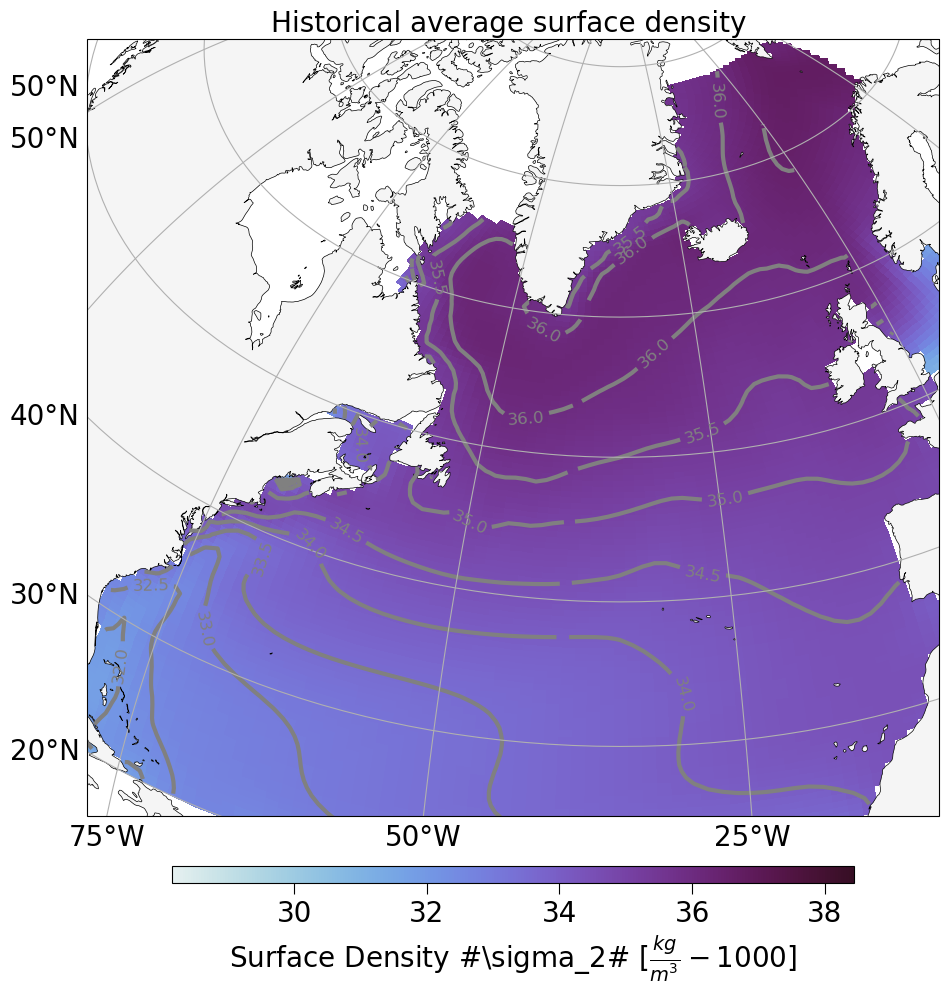

In [11]:
#plotting_data = ds_sigma.SIGMA_2.sel(z_t=slice(5.000000e+02, 1.050000e+04)).mean(dim=['z_t','time']).roll(nlon=+100)
#plotting_data = ds_sigma.SIGMA_2.sel(z_t=slice(5.0000000e+02, 9.8470586e+04)).mean(dim=['z_t','time']).roll(nlon=+100)
plotting_data = ds_sigma.SIGMA_2.sel(z_t=5.0000000e+02).mean(dim=['time']).roll(nlon=+100)
cbar_kwargs = {'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
               'label': r'Surface Density #\sigma_2# [$\frac{kg}{m^3} -1000$]', 'pad': 0.05}
labelsize = 20

plt.figure(figsize=(11, 13))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=40, central_longitude=-35))
ax.set_extent([-80, -10, 25, 80], crs=ccrs.PlateCarree())

pc = plotting_data.plot.pcolormesh(ax=ax,
                                   transform=ccrs.PlateCarree(),
                                   x='TLONG',
                                   y='TLAT',
                                   cbar_kwargs=cbar_kwargs,
                                   cmap=cmo.dense)

pc.colorbar.ax.xaxis.label.set_size(labelsize)
pc.colorbar.ax.tick_params(axis='x', labelsize=labelsize, size=8)
ax.tick_params(axis='both', which='both', labelsize=labelsize, size=6)

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': labelsize}
gl.ylabel_style = {'size': labelsize}

ax.add_feature(nature_coast)
plt.title('Historical average surface density ', fontsize=labelsize)

contour_levels = np.arange(np.floor(plotting_data.min().item()), 
                           np.ceil(plotting_data.max().item()) + 0.5, 0.5)
cs = ax.contour(ds_sigma.TLONG, ds_sigma.TLAT, 
                plotting_data.where(mask > 0), 
                levels=contour_levels, 
                linewidths=3, 
                colors='gray', 
                transform=ccrs.PlateCarree())
ax.clabel(cs, fmt='%1.1f', inline=True, fontsize=12)

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'Density_map.png', bbox_inches='tight', dpi=300)        